# Learning Objectives

- Introduce production workflows for ML model deployment using Docker.
- Illustrate monitoring workflows as a key component of MLOps practise.
- Present a comprehensive workflow to monitor models in production for different types of drift

# Setup

In [1]:
import json
import requests
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp
from collections import Counter

In [2]:
sns.set_context('talk')

# Business Use Case

To recap, the business problem we are trying to tackle is:

<div class="alert alert-block alert-success">
 
For this session consider the case of predicting machinery failure based on the quality of the machinery and its wear and tear. Such predictions often require an expert intervention on the shopfloor and result in high dependencies on the expert.

The dataset used in this session is hosted on [OpenML](https://www.openml.org/search?type=data&status=active&id=4289033et).

</div>

# MLOps Projects

## The Build-Deploy Structure

MLOps projects typically have two main components: a build phase and a deploy phase. These two phases align with the DevOps cycle, where development (Dev) and operations (Ops) teams collaborate to ensure efficient and reliable software delivery. The build phase focuses on the development side, involving tasks such as data preprocessing, feature engineering, model training, and evaluation. The deploy phase, on the other hand, emphasizes the operational side, encompassing tasks such as model deployment, monitoring, and scalability. Key parts of these two parts of a project are encoded as a set of source files (usually `.py`) and configuration files (usually `.yml`).

The two phases - build & deploy - require creation and consumption of business resources, and hence need to go through a careful approval process. In a robust MLOps CI/CD pipeline, it is crucial to incorporate approvals at key stages to maintain control and governance over model deployments. Let us give this aspect of MLOps a closer look.

## Approvals

Approvals serve as checkpoints that ensure models undergo thorough validation, collaboration, and monitoring before being deployed to production environments. The figure below depicts the three main approval steps commonly implemented in a MLOps CI/CD pipeline and their significance in enabling a smooth and controlled model deployment process.

![approvals](figures/approvals.drawio.png)

**1. Approval for Model Registration:**

The first approval point occurs when a model is deemed ready for registration as a deployable entity. At this stage, a formal handoff takes place between the Development (Dev) and Operations (Ops) teams. The model artifacts, including trained models, preprocessing code, and other relevant resources, are shared between the teams.

During this handoff, the Dev team provides the Ops team with comprehensive documentation, explaining the model's architecture, dependencies, input/output specifications, and any specific deployment considerations. This documentation facilitates smooth collaboration and transfer of knowledge between the teams, ensuring a seamless transition from development to deployment.

Subsequently, the build repository executes the model registration as a separate step. This process typically involves packaging the model and its dependencies into a containerized format suitable for deployment. The registration step enables the Ops team to maintain a central repository of approved models, streamlining the deployment process and ensuring consistency across different environments.

**2. Approval for Staged Endpoint:**

Once a model is registered, the next approval stage involves mirroring the model from the Dev environment and creating a deployment staging area. The staging area serves as a controlled environment for short-term monitoring and further validation of the model's behavior.

In the staging area, various monitoring checks are performed to assess the model's performance, robustness, and compliance with business requirements. These checks may include test data evaluations, comparing model predictions against expected outputs, and running specific tests to ensure the model operates within acceptable performance thresholds.

The approval for the staged endpoint confirms that the model has successfully passed the necessary validation tests and meets the predefined criteria for deployment. This approval signifies that the model is ready for promotion to a production-like environment while minimizing the risk of potential issues affecting the live system.

**3. Approval for Production Endpoint and Long-Term Monitoring:**

After successfully passing the staged endpoint phase, the model artifacts used in the staging deployment are reused for the final release. The Ops team proceeds with creating the production endpoint, which represents the model's deployment in the live production environment.

The production endpoint undergoes rigorous testing and verification to ensure it meets stringent quality standards. This includes comprehensive testing against real-world data, performance evaluations under various load conditions, and security assessments to safeguard sensitive information.

Once the production endpoint is deployed, it is placed under long-term monitoring mode. Continuous monitoring is critical to detect any anomalies, drift, or degradation in the model's performance over time. The Ops team closely monitors key performance indicators, such as accuracy, latency, and resource utilization, to proactively identify any potential issues and take appropriate remedial actions.

With this conceptual understanding of the Ops side of the MLOps process, let us look at the details of how this is executed in practise.

# Containerized Deployment

There are two broad pathwats where models could be deployed (represented in the figure below).

![deployment-pathways](figures/deployment-pathways.drawio.png)

## Web/API deployment

In this notebook, our journey will begin with the serialized model we saved in the previous notebook and layer in all the steps to deploy this model on the web using an API. But what exactly is an API?

### What is an API?

A common way to deploy a model on the web is to wrap the saved model as a API service and allow users (clients) to send requests. The requests are parsed into the appropriate input format by the service and presented to the model for inference. This inference is returned to the user as a response. Each request is handled by a specific resource (in our case a model) that is identified by a unique *endpoint*. 

Think of endpoints as the unique URL that is shared with the client to interface with the model; all they can do is to send a request to the endpoint (i.e., they have no access to any detail on how the response is generated). Intuitively, it is like a storefront (a unique address) where they come to collect their predictions. They do not worry about *how* the predictions are made.

But what exactly is an Application Programming Interface (API)?

APIs prescribe the mechanism through which any two computers can exchange information over a network. Given that there could be many ways to do this, we felt that it would be prudent to formalize this exchange as a set of rules that we agree 

![rest](figures/rest.drawio.png)

REpresentational State Transfer (REST) APIs are programming language agnostic and encode a set of rules that constitute a REST-ful API. These rules are:

- Clients can only make POST, GET, PUT, or DELETE requests
- These requests can contain an optional payload (usually a [JSON object](https://www.json.org/json-en.html))
- All requests should return a response with a code indicating the status of the response (200's - Success, 400's - Improper request, 500's - Server side errors)

In the context of ML deployment, clients send a POST request with a payload containing the input data needed by the model to make a prediction. For example, to get a classification result on their input, showrooms should attach the features of a diamond as a payload and upload it to the unique URL encoded by the endpoint. The server parses this input, presents it to the model, collects the prediction and sends a response (along with a status code) back to the client. In sum, customers *post* an input and the business serves a response.

Common web frameworks used in production that implement the REST framework in Python are [Flask](https://flask.palletsprojects.com/en/2.1.x/) and [FastAPI](https://fastapi.tiangolo.com/). Flask is a popular REST implementation that we will use in this notebook. The advantage of Flask is that owing to its longer existence, however is that it enjoys a wider ecosystem compared with FastAPI. Beyond these general purpose implementations, specialized implementations also exist. For example, [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) implements the REST framework in C++ for TensorFlow models and hence can be more performant for deep learning models.

### Why APIs?

In the context of serving infrastructure, key metrics that underpin performance of a deployed system (not necessarily a ML-infused one) are: latency, throughput and cost. 

- Latency = time taken per prediction

- Throughput = number of predictions made per unit time

- Cost, typically measured as the variable cost incurred per prediction

Good deployments balance these three metrics and often result in business metric improvements.


The final choice of the target architecture for deployment also rests on the mix of latency, throughput and cost that is best suited to achieve business objectives. 

Deploying ML models on the web is a great way to balance the costs incurred in serving complex models and the resources available to serve these models. Since the serving infrastructure can be controlled, API-driven deployment is often scalable in terms of performance. Once a model is built, we typically start with a specification of the serving infrastructure, and keep the specification constant until the cap on predictive performance is maintained (monitoring is crucial).

If performance (i.e., latency, throughput and cost) degrades, we revisit the serving infrastructure and change if necessary.

## Preparing for deployment

### Step 1: Serialize Model

In [3]:
saved_model_path = 'models/model-v1.joblib'

In [4]:
saved_model = joblib.load(saved_model_path)

In [5]:
saved_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type'])])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=9, n_estimators=535,
                                            random_state=42))])

Note that this is a *saved model* that we have reloaded from a binary file. We have not estimated this model in this notebook. Once a binary is created, the model file can be easily shared with no dependence on the packages that were needed to build the model. 

An important strength of the `joblib` format is that it allows us to capture all the steps of the model pipeline including the preprocessing steps in tact.

### Step 2: Write a model server

Once we have a model binary, we wrap this binary within a server that parses requests in a REST-ful way (i.e., it follows the rules specified by the REST protocol). This is often referred to as local deployment and is usually conducted in a staging environment, that is, a server that mimics the production setting (expect for the fact that it is not live).

Specifically, our model server (`app.py`) should be able to load the serialized model from disk, parse incoming client requests (i.e., the images they send to the REST API) and send predictions as a response with the appropriate status code. In case, there are errors (client-side or server-side) the server should be able to clearly communicate the type of errors to the client.

We will use `Flask` to write out model server. The server should be able to handle both streaming requests (i.e., one request at a time) and batch requests (i.e., collections of requests at a time).

The three components to be handled - requests, predictions and responses - are handled by three crucial components of flask that we call in the code fragment below.

```python
from flask import request, Flask, jsonify
```

In the above code:
- `request` captures the incoming request (and its JSON payload) and converts it into a Python dictionary.
- `Flask` allows us to write the prediction logic as a function that will be executed on the input received from the `request`
- `jsonify` formats the response from the Python runtime to be neatly packaged as a JSON payload attached with the response

In this way, we rely on `Flask`'s powerful machinery to handle requests in a REST-ful way.

### Step 3: Test server response

Now that the server is built, we test the server by running ```python app.py``` at the command line. This ensures that the model is loaded and the server is ready, listening to incoming requests.

The local deployment can now receive requests and return responses. Let us gather some test data and use these images as payload to the server.

To manage the process of sending HTTP requests with an attached payload, we use the `requests` library (so we can avoid using a browser or `curl`).

The `requests` library also automates an important mechanism through which customers access models - sending a HTTP request. 

In [6]:
local_machine_model_url = "http://localhost:8000/v1/equipment"
local_machine_model_batch_url = "http://localhost:8000/v1/equipmentbatch"

In [7]:
test_df = pd.read_csv("data/20230921_test_features.csv")
test_targets = pd.read_csv("data/20230921_test_target.csv")

In [8]:
test_df['ground_truth'] = test_targets

In [9]:
test_df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],ground_truth
0,L,300.8,310.3,1538,36.1,198,0
1,M,303.6,311.8,1421,44.8,101,1
2,M,298.3,307.9,1485,42.0,117,0
3,L,303.3,311.3,1592,33.7,14,0
4,L,302.4,310.4,1865,23.9,129,0


In [10]:
stream_payload = {
    'Air temperature [K]': 300.8,
    'Process temperature [K]': 310.3,
    'Rotational speed [rpm]': 1538,
    'Torque [Nm]': 36.1,
    'Tool wear [min]': 198,
    'Type': 'L'
}

In [11]:
response = requests.post(local_machine_model_url, json=stream_payload)

In [12]:
print(response.status_code)

200


In [13]:
print(response.json())

{'Failure expected?': 'no'}


In [14]:
batch_input = {
    'file': test_df.sample(100).to_csv(header=True, index=False)
}

In [15]:
response = requests.post(
    local_machine_model_batch_url, 
    files=batch_input
)

In [16]:
print(response.json())

{'predictions': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


### Step 4: "Containerize" the server & run

Once the server logic is validated, we need to package the model + server along with all the runtime requirements into a container. This ensures that the server could be deployed easily on any runtime by eliminating manual duplication of the configuration options needed to run the server. 

Docker is the most popular containerization tool that allows us to quickly package all runtime requirements into a reusable container. Once the containerization is done, the container is typically ported over to a *canary environment* where a small fraction (1% - 5%) of real-time traffic is sent to the containerized app to iron out system dependencies.

The steps involved in containerization of the model server is presented below.

![docker](figures/docker.drawio.png)

The first step in containerization is to specify all the steps needed to run our model on *any* server by detailing these steps out in a `Dockerfile`. Let us look at the contents of the `Dockerfile` of our API to understand how the packaging is conducted.

```docker

# create a minimal linux image with Python 3.9 installed 
FROM python:3.9-slim

# create a working directory within the container
WORKDIR /app

# copy all files in the source directory to the working directory
COPY . .

# install all the requirements required for the model to serve predictions
RUN pip install -r requirements.txt

# run the gunicorn server from within the container
CMD ["gunicorn", "--bind", "0.0.0.0:8000", "--workers", "4", "--threads", "2", "app:maintenance_prediction_api"]
```

As the `Dockerfile` above shows, we list out all the steps required to be able to run the Flask server. These steps involve creating a Python runtime, copying over the required files into the container image, installing the packagers specified in `requirements.txt` and finally executing the command `gunicorn ...`. [Gunicorn](https://gunicorn.org/) is a production-grade, high performance WSGI server for UNIX. It complements the Flask app and delineates the app functionality (encoded in `app.py`) and the server interface.


In this way, the `Dockerfile` acts as a blue print for the creation of a container. The next stage is to actually build an image from the blue print specified in the `Dockerfile`. This is achieved using the `docker build` command that allows us to also tag the image that is created using the instructions in the Dockerfile. For example, `docker build -t maintenancepredictor:1.0` builds a Docker image from the instructions mentioned in the `Dockerfile` placed in the current directory. 

Running `docker images` should now show the images that were built.

Once built, this docker image can then either be shared with the stakeholders in the organization through a private repository (locally or on [cloud](https://cloud.google.com/container-registry)) or publicly ([DockerHub](https://hub.docker.com/)). They will now have access to the model + configuration needed to run a server wrapped around the model. 

The next step after a docker image has been created and shared is to run the docker image on the host. 

The command `docker run -p 8000:8000 maintenancepredictor:1.0` achieves this step, where the container is now running.

The container is finally created and ready to serve predictions. A significant advantage of containerization is that each container essentially acts as a self-contained microservice enabling rapid scaling.

Handling multiple versions of model containers is handled by the tag. For example, the command `docker run -p 8000:8000 maintenancepredictor:latest` runs the production server using the container that was built most recently.

# Monitoring

In the context of machine learning model deployment, testing the endpoints created in the previous step is crucial to ensure the reliability and accuracy of the model in a production environment. After developing and configuring the model's endpoints, it is necessary to assess their performance by exposing them to various test datasets.

To validate the model's effectiveness, it is important to use test data that the model has never encountered during training. This ensures that the model can handle inputs it hasn't been exposed to before and can generalize well beyond the training data. By using unseen test data, developers can identify any potential issues, limitations, or errors that may arise when processing unfamiliar inputs.

Initially, synthetic data can be employed to test the model before its official deployment to customers or real-world usage. Synthetic data is artificially generated and can be designed to cover different edge cases, challenging scenarios, or specific patterns that may not be prevalent in real-world data. By using synthetic data, developers can deliberately create testing conditions that assess the model's robustness, resilience to outliers, and handling of unusual or rare inputs.

However, while synthetic data provides a controlled environment for testing, it may not fully capture the complexity and diversity of real-world data. Therefore, after the model is deployed and actively used in production, it is crucial to transition to using live data for testing. Live data encompasses the actual input and output produced by the model during its operation in the real world. This allows developers to evaluate the model's performance under real-world conditions, considering factors such as data distribution shifts, concept drift, and evolving patterns that may occur over time.

In practise, by using synthetic data before deployment and transitioning to live data in the production environment, developers can identify and address potential errors, validate the model's generalization capabilities, and adapt the system to handle distribution shifts and real-world complexities effectively.

In [17]:
model_url = "http://52.172.239.17:8000/v1/equipment"
model_batch_url = "http://52.172.239.17:8000/v1/equipmentbatch"

In [18]:
test_df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],ground_truth
0,L,300.8,310.3,1538,36.1,198,0
1,M,303.6,311.8,1421,44.8,101,1
2,M,298.3,307.9,1485,42.0,117,0
3,L,303.3,311.3,1592,33.7,14,0
4,L,302.4,310.4,1865,23.9,129,0


## Short-term monitoring

Before the model server can be accessed by customer requests, a set of short-term checks need to be conducted in a staging area where controlled traffic (i.e., not live) is presented to the model. The decision calculus for short-term monitoring on the staging endpoint is presented below.

![stagingendpoint](figures/staging-endpoint.drawio.png)

Specific business checks that we conduct in the context of classification models are: perturbation analysis and critical subgroup analysis.

### Perturbation Analysis

Perturbation analysis involves introducing deliberate changes or perturbations to the input data and observing the corresponding impact on model predictions. This task helps evaluate the stability and robustness of the model. By systematically perturbing variables or introducing simulated variations, organizations can assess how sensitive the model is to different inputs and determine if it responds in an expected manner. For instance, in a credit risk assessment model, perturbation analysis could involve altering individual features such as income or credit utilization ratios to observe how the model's predictions change. This analysis helps identify potential vulnerabilities or inconsistencies in the model's behavior and informs the need for recalibration or retraining.

In [19]:
baseline_payload = {
    'Air temperature [K]': 300.8,
    'Process temperature [K]': 310.3,
    'Rotational speed [rpm]': 1538,
    'Torque [Nm]': 36.1,
    'Tool wear [min]': 198,
    'Type': 'L'
}

In [20]:
response = requests.post(model_url, json=baseline_payload)

In [21]:
print(response.json())

{'Failure expected?': 'no'}


In [22]:
test_payload = {
    'Air temperature [K]': 301.8,
    'Process temperature [K]': 310.3,
    'Rotational speed [rpm]': 1538,
    'Torque [Nm]': 36.1,
    'Tool wear [min]': 198,
    'Type': 'L'
}

In [23]:
response = requests.post(model_url, json=test_payload)

In [24]:
print(response.json())

{'Failure expected?': 'no'}


### Monitoring Critical Subgroups

In some applications, it is important to monitor the performance of machine learning models specifically for critical subgroups or segments of the population. These subgroups may be defined by demographic characteristics, geographic location, or other relevant factors. For example, in healthcare, it is crucial to ensure that a medical diagnosis model performs well across different demographic groups to avoid bias or disparities in patient care. Short-term monitoring tasks involve regularly assessing model performance metrics, such as accuracy or false positive rates, specifically for these critical subgroups. If significant disparities or performance gaps are detected, further investigation can be conducted to understand the root causes and take necessary corrective actions, such as retraining the model or adjusting its decision thresholds.

In this case, we could test the model by presenting the edge cases of critical equipement failures and ascertaining that the model is able to detect these crucial failures.

In [25]:
critical_equipment_payload = {
    'Air temperature [K]': 303.6,
    'Process temperature [K]': 311.8,
    'Rotational speed [rpm]': 1421,
    'Torque [Nm]': 44.8,
    'Tool wear [min]': 101,
    'Type': 'M'
}

In [26]:
response = requests.post(model_url, json=critical_equipment_payload)

In [27]:
print(response.json())

{'Failure expected?': 'no'}


## Long-term monitoring

Once short-term monitoring checks pass, the endpoint can receive full-fledged  live traffic. We then move on to the long-term monitoring phase where a series of tests are designed to alert the data scientist about deviations in model predictions or deviations in features received at the end point.

These deviations are conceptualized as data drift and model drift. A reference implementation of the long-term monitoring workflow is presented below. This workflow is not a one-time process. It is periodically executed according to the service level agreement (e.g., every one hour or every $n$ predictions).

![drift](figures/production-endpoint-monitoring.drawio.png)

As the figure above indicates, there are three key long-term monitoring checks that need to be conducted to ensure model quality. These checks are repeatedly executed using automation, and it is common practice to take a random sample of the full traffic for executing these three checks. There is also a priority order for these checks.

1. Distribution Deviation Check:
   The first check involves comparing the distribution of model predictions on the sample with the target observed in the training data. This comparison ensures that there is no target drift.

2. Feature Consistency Check:
   The second check involves comparing the features received in the request with those present in the training data. This ensures that there is no data drift.

3. Prediction Validation Check:
   The third check involves comparing the model predictions with the ground truth. This ensures that there is no model drift.

To understand if there is model drift or data drift, we need to access the logs where incoming requests and model responses from a random sample of live traffic are collected. We will also need the training data so that appropriate baselines can be created.

In [28]:
training_data = pd.read_csv('data/20230921_training_features.csv')
training_targets = pd.read_csv('data/20230921_training_target.csv')

In [29]:
training_data['target'] = training_targets

In [30]:
test_samples = test_df.sample(750)

In [31]:
batch_input = {
    'file': test_samples.to_csv(header=True, index=False)
}

In [32]:
response = requests.post(
    model_batch_url, 
    files=batch_input
)

In [40]:
model_predictions = np.array(response.json()['predictions'])

In [41]:
ground_truths = test_samples['ground_truth'].values

### Target Checks

This is a very critical check especially when the ground truth is delayed. By comparing the distribution of the predictions with the target present in the training data, we can flag deviations beyond expected amount of variation.

In the plots below, we compare the distribution of predictions from the AWS endpoint logs (~30% random sample of live traffic) with the distribution of the target in the training data.

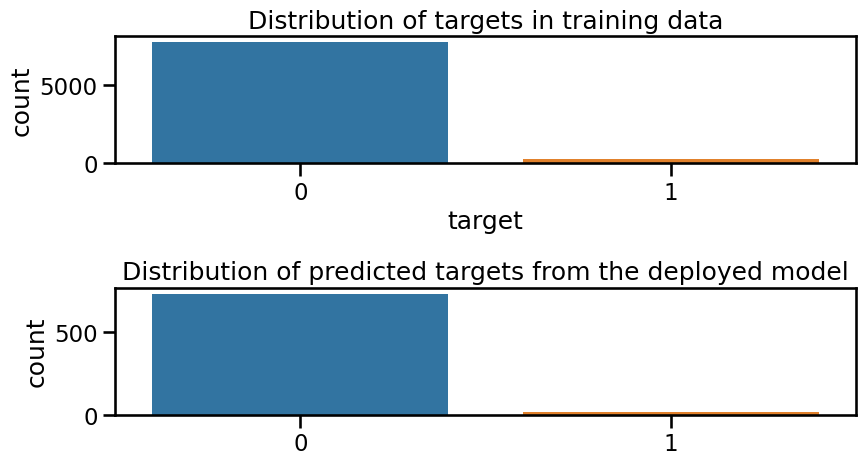

In [77]:
plt.figure(figsize=(9, 5))
plt.subplot(211)
sns.countplot(x='target', data=training_data)
plt.title("Distribution of targets in training data")
plt.subplot(212)
sns.countplot(x=model_predictions)
plt.title("Distribution of predicted targets from the deployed model")
plt.tight_layout()

### Data Drift

We define data drift as the phenomenon of deviation or changes occurring between the distribution or characteristics of the training features and the corresponding live features used for real-time predictions or analysis. It indicates a shift in the underlying data generating process and can have significant implications for the performance and reliability of machine learning models or data-driven systems. Here are a few examples of data drift:

1. Example of Numeric Data Drift:
   Imagine a predictive model trained on historical sales data of a retail store. The model learns patterns and relationships between features such as product price, customer demographics, and time of purchase. Over time, if there is a shift in customer behavior, such as a change in purchasing preferences or economic conditions, the distribution of live data features (e.g., customer income levels) may deviate from the training data. This data drift can impact the accuracy and effectiveness of the model's predictions.

2. Example of Categorical Data Drift:
   Consider a customer churn prediction model trained on telecom customer data. The model learns from features like customer demographics, subscription plans, and service usage patterns. However, if there are changes in the market or industry regulations, new subscription plans may be introduced or existing plans may be modified. These changes can lead to shifts in the distribution of live data features, such as the introduction of new plan categories or changes in service usage patterns, causing data drift that can affect the model's ability to accurately predict customer churn.

Numeric data drift can be tested using the **Kolmogorov-Smirnov (K-S) test**. The only change is that here, we check if there is any difference in distributions of numeric features in the live data and training data. 

Here's a short explanation of how the K-S test works in this scenario:

1. Hypotheses:
   The K-S test involves defining two hypotheses:
   - Null Hypothesis ($H_0$): The distribution of model predictions is the same as the distribution of targets in the training data.
   - Alternative Hypothesis ($H_1$): The distribution of model predictions differs from the distribution of targets in the training data.

2. Test Statistic:
   The K-S test calculates a test statistic known as the Kolmogorov-Smirnov statistic ($D$), which represents the maximum difference between the cumulative distribution functions (CDFs) of the two distributions being compared.

3. Significance Level:
   A significance level ($\alpha$) is chosen to determine the threshold for rejecting the null hypothesis. Commonly used values for alpha are 0.05 or 0.01, indicating a 5% or 1% level of significance, respectively.

4. Decision:
   In the K-S test, the p-value is calculated, which represents the probability of obtaining a test statistic as extreme as the one observed, assuming the null hypothesis is true. The p-value is then compared to the chosen significance level ($\alpha$).

   - If the p-value is greater than $\alpha$, we fail to reject the null hypothesis, indicating no significant difference between the distributions.
   - If the p-value is less than or equal to $\alpha$, we reject the null hypothesis, suggesting a significant difference between the distributions.

   By using p-values as the decision point, the K-S test allows for a more quantitative assessment of the difference between the distributions, providing a clearer basis for decision-making in evaluating model quality and detecting potential drift.

It's important to note that the K-S test assumes that the samples being compared are independent and that the distributions being tested are continuous. The K-S test is a non-parametric test, which means that it does not make any assumptions about the underlying distribution of the data. This makes it a versatile test that can be used with a variety of data types.

Categorical data drift can be ascertained using the **Population Stability Index (PSI) test**. PSI is a measure used to assess the stability of a population over time. It compares the distribution of a specific variable - numeric or categorical - (such as age, income, or any other relevant factor) in a baseline population to its distribution in a subsequent population. PSI helps identify significant changes in the population's characteristics.

The formula for calculating PSI is as follows:
$$
\textbf{PSI} = \sum_{\text{classes}} (\rho_{\text{actual}} - \rho_{\text{expected}}) * ln(\rho_{\text{actual}} / \rho_{\text{expected}})
$$

Where:
- $\rho_{\text{actual}}$ refers to the proportion of each class of the categorical variable in live data.
- $\rho_{\text{expected}}$ refers to the proportion of each class of the categorical variable in training data.

In [43]:
def psi(actual_proportions, expected_proportions):

    psi_values = (actual_proportions - expected_proportions) * \
        np.log(actual_proportions / expected_proportions)

    return sum(psi_values)

In [44]:
target = 'Machine failure'
numeric_features = [
    'Air temperature [K]', 
    'Process temperature [K]', 
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]
categorical_features = ['Type']

In [45]:
p_value_threshold = 0.05
psi_threshold = 0.1
features_with_data_drift = []

In [46]:
for k, feature in enumerate(test_samples.columns):

    if feature in numeric_features:
        statistic, p_value = ks_2samp(
            training_data[feature].values, 
            test_samples[feature].values
        )
        
        if p_value < p_value_threshold:
            features_with_data_drift.append(feature)

    elif feature in categorical_features:
        psi_value = psi(
            test_samples[feature].value_counts(normalize=True).values,
            training_data[feature].value_counts(normalize=True).values
        )
        
        if psi_value > psi_threshold:
            features_with_data_drift.append(feature)

In [47]:
features_with_data_drift

[]

For this test sample, there is no evidence of data drift.

### Model Drift

#### Accounting for ground truth

In long-term model monitoring, the timing of observing the ground truth plays a crucial role in determining the monitoring approach and its impact on decision-making. There are two distinct situations: one where the ground truth is immediately observed and available for comparison with model predictions, and the other where there is a lag in observing the ground truth. Let's delve deeper into each scenario with relevant examples.

In the first situation, where the ground truth is immediately observed, monitoring becomes a real-time process. This means that as soon as the actual outcomes or labels are known, they can be compared with the predictions made by the model. For instance, in fraud detection, a machine learning model is deployed to flag potentially fraudulent transactions. With immediate ground truth observation, the model's predictions can be compared to whether a transaction was indeed fraudulent or not. If the model flags a transaction as fraudulent but it turns out to be legitimate, it indicates a false positive. Real-time monitoring allows for quick feedback and adjustments to the model to minimize false positives or negatives and improve its performance.

On the other hand, when there is a lag in observing the ground truth, monitoring becomes more challenging. In some cases, it may take time to collect the necessary data or obtain feedback on the actual outcomes. Consider a recommendation system for an online streaming platform. The model suggests content to users based on their viewing history and preferences. However, the ground truth, which is the user's feedback on whether they liked or disliked the recommended content, may not be immediately available. In such cases, monitoring involves collecting user feedback over time and analyzing it periodically to assess the effectiveness of the recommendations. This lag in ground truth observation introduces delays in model evaluation and necessitates robust tracking mechanisms to ensure accurate feedback is collected for ongoing monitoring and improvement.

Understanding these two situations highlights the importance of considering the timing of ground truth observation in designing effective monitoring strategies. Real-time monitoring enables immediate action and adjustment, while lagged monitoring requires careful tracking and feedback collection to evaluate model performance accurately. Both approaches contribute to the iterative process of refining machine learning models and ensuring their continued relevance and impact on business outcomes.

#### Instantaneous ground truth

To confirm model drift, we compare the ground truth of live data with the predictions from the deployed model. This involves extracting samples where the predictions and ground truth are compared, followed by conducting a statistical test to determine if there is a significant difference between the model predictions and the ground truth. 

For classification problems, we compare the ground truth classifications of a random sample with the model's predictions. This comparison utilizes the PSI test we have seen earlier.

By utilizing paired two-sample t-tests for regression problems and the PSI test for classification problems, we can assess the significance of the differences between the model predictions and the ground truth, allowing us to identify potential model drift.

In [48]:
counter_model_predictions = Counter(model_predictions)
counter_ground_truths = Counter(ground_truths)

In [49]:
prediction_proportions = {
    i: counter_model_predictions[i]/len(model_predictions) for i in counter_model_predictions
}

In [50]:
ground_truth_proportions = {
    i: counter_ground_truths[i]/len(model_predictions) for i in counter_ground_truths
}

In [51]:
prediction_proportions

{0: 0.976, 1: 0.024}

In [52]:
ground_truth_proportions

{0: 0.9746666666666667, 1: 0.025333333333333333}

In [54]:
live_proportions = np.array(list(prediction_proportions.values()))


In [55]:
ground_truth_proportions = np.array(list(ground_truth_proportions.values()))

In [58]:
psi(live_proportions, ground_truth_proportions)

7.391236730907829e-05

Since the PSI value is less than 0.1, we conclude that there is no model drift. 

# Summary

![mlops-summary](figures/mlops-summary.drawio.png)

![mlops-mindmap](figures/mlops-mindmap.drawio.png)